In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

We also renumber the bins so that bins 0-3 correspond to library 1, bins 4-7 correspond to library 2, and bins 8-11 correspond to library 3.

In [6]:
# Load example data
data_df = pd.read_csv('data/xylE_data.csv.gz')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head(10)

test N: 369,710
training + validation N: 1,477,518


,set,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9,ct_10,ct_11,x
0,training,0,0,0,0,0,0,0,0,0,0,0,3,AAACAATAGCATTGTTCTTATCAATTTTGGATAAGTATTATAATTA...
1,training,0,0,0,0,0,0,0,0,0,0,0,5,AAACAATAGTATTGCTTTTATCAATTTAGGATAATTATCACGATTA...
2,training,0,0,0,0,0,0,0,0,0,0,0,2,AAACAATAGTATTGCTTTTATCATTTTTGGAAAATTAACACGATTA...
3,training,0,0,0,0,0,0,0,0,2,0,0,1,AAACAGGAGTATTGTTTTTAGCAATTCTGGATAATTAGCACAATTA...
4,validation,0,0,0,0,0,0,0,0,0,1,0,0,AAACCATAGTATTGTTTACATTAATTTGGGATAATTATTACAATTA...
5,validation,0,0,0,0,0,0,0,0,0,2,0,0,AAACGATAGTATCGTATTTATCATTTTTGGATAAATATCACAATTA...
6,training,0,0,0,0,0,0,0,0,1,0,0,0,AAACTATAGTATTGTTTTTATTAATTTTCGATAATTATCAAAATTA...
7,training,0,0,0,0,0,0,0,0,0,0,0,5,AAATAATTGGATTGTTTTTATCAATCTTGGAGAATTATCACAATTA...
8,training,0,0,0,0,0,0,0,0,0,0,0,6,AACAATTAGTATTGTTGTTATCAATTTTGTATAGTTATCACAATTT...
9,validation,0,0,0,0,0,0,0,0,0,0,0,1,AACCAAGAGTATTGTTTTCATCAATTTTGGATAAAGATCACAATCA...


In [7]:
# List beginning and end of each variant region, in Python coordinates
lib_coords_dict = {
    1: [97, 150],
    2: [51, 105],
    3: [0, 60]
}

In [8]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A','C','G','T']

y_cols = data_df.columns[1:-1]
Y = len(y_cols)
print(f'L={L}, Y={Y}')

# get test set data.
x_test = test_df['x'].values

L=150, Y=12


In [9]:
# instantiate gpmap object
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)


2022-03-31 20:22:01.965685: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Create measurement process object(s)

In [10]:
# I think this shouldn't require any positional arguments.
# mp_GE = mavenn.measurement_process_layers.GlobalEpistasisLayer(K=50,
#                                                                eta=1e-5,
#                                                                monotonic=True)
mp_mpa_1 = mavenn.measurement_process_layers.DiscreteAgnosticMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=4,
                                                                      K=50,
                                                                      eta=1e-5,)

mp_mpa_2 = mavenn.measurement_process_layers.DiscreteAgnosticMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=4,
                                                                      K=50,
                                                                      eta=1e-5,)

mp_mpa_3 = mavenn.measurement_process_layers.DiscreteAgnosticMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=4,
                                                                      K=50,
                                                                      eta=1e-5,)


In [11]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=[mp_mpa_1, mp_mpa_2, mp_mpa_3])

In [12]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 612)]       0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 600)          0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer (Additiv  (None, 1)           601         ['Sequence_only[0][0]']          
 eGPMapLayer)                                                                                     
                                                                                              

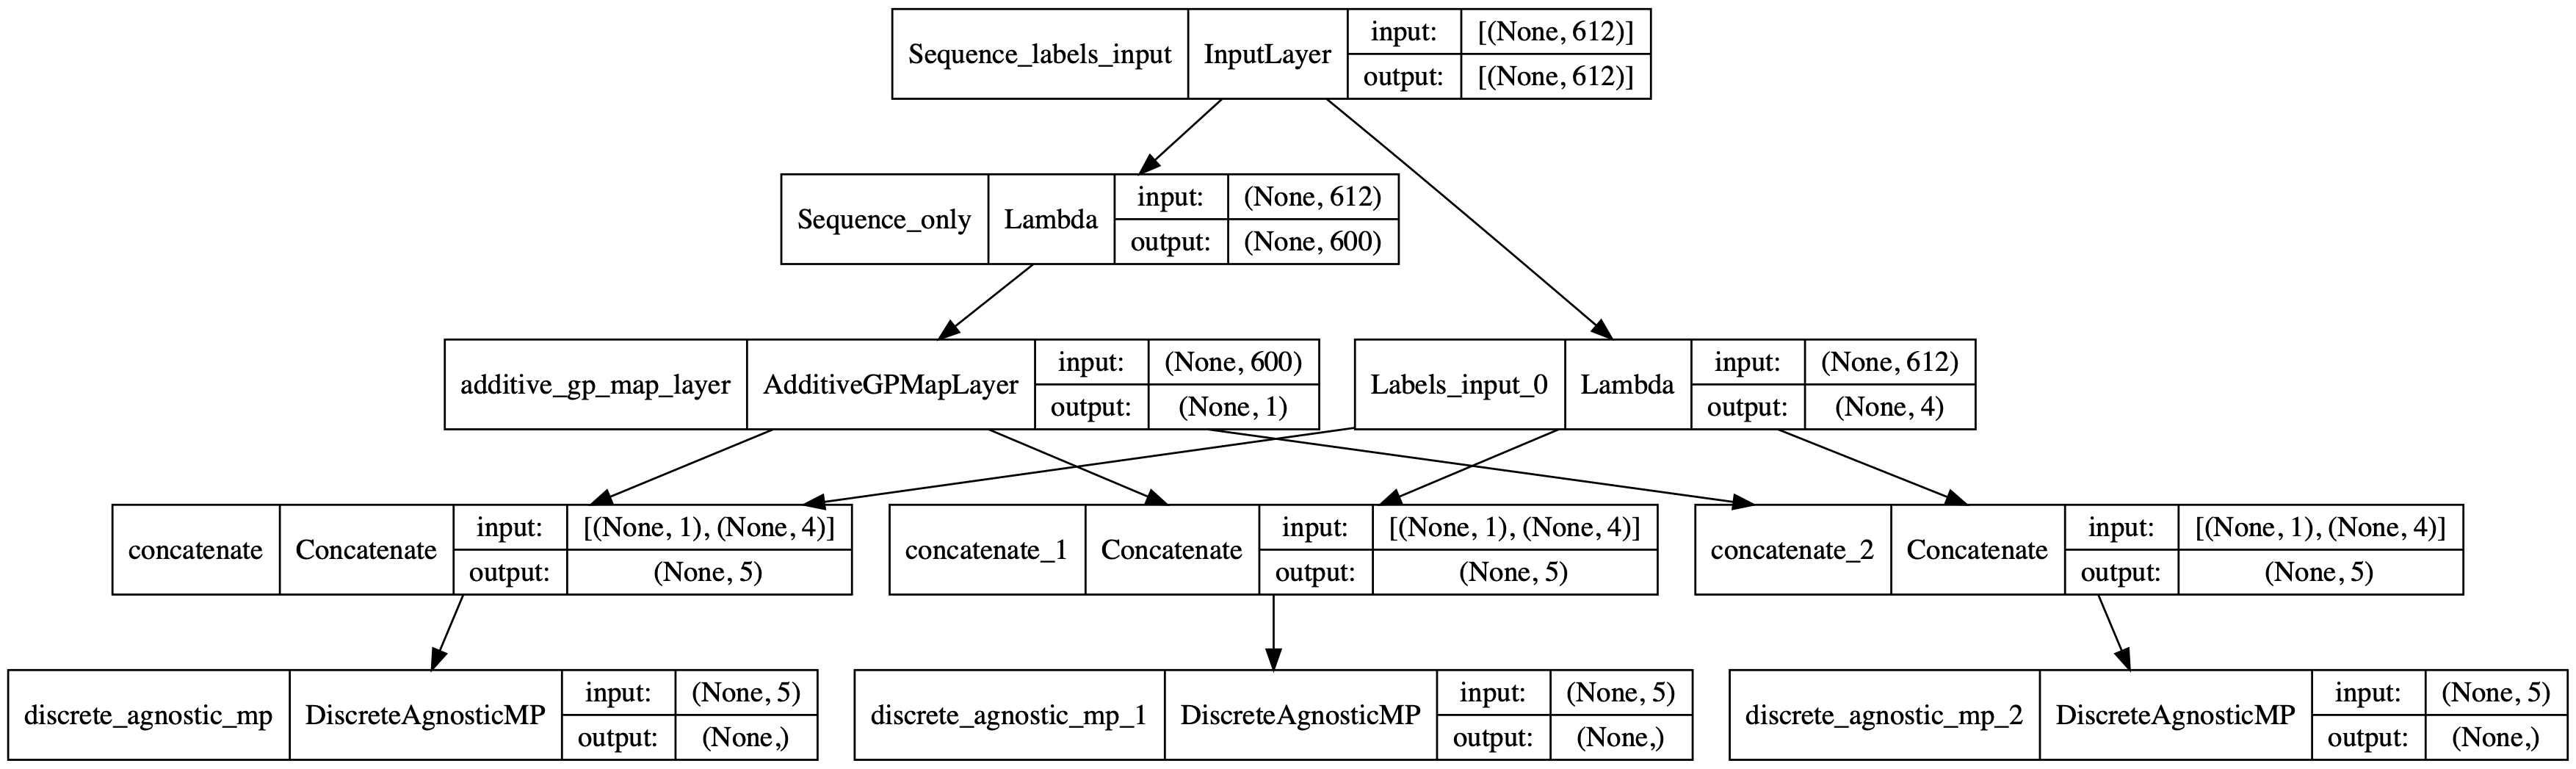

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True,show_dtype=False,dpi=200)

In [18]:
# Set training data
model.set_data(x=data_df['x'].values,
               y_list=[data_df[y_cols[0:4]].values,data_df[y_cols[4:8]].values,data_df[y_cols[8:12]].values],
               validation_flags=(data_df['set']=='validation'),
               shuffle=False)


N = 1,477,518 observations set as training data.
Using 25.0% for validation.
Time to set data: 1.31e+02 sec.


In [19]:

# Fit model to data
model.fit(learning_rate=.005,
          epochs=200,
          batch_size=500,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=False)

Epoch 1/200
2216/2216 [==============================] - 47s 19ms/step - loss: 2963.2961 - discrete_agnostic_mp_loss: 987.7563 - discrete_agnostic_mp_1_loss: 987.7491 - discrete_agnostic_mp_2_loss: 987.7625 - I_var: 0.1681 - val_loss: 3267.5706 - val_discrete_agnostic_mp_loss: 1089.1791 - val_discrete_agnostic_mp_1_loss: 1089.1885 - val_discrete_agnostic_mp_2_loss: 1089.1854 - val_I_var: nan
Epoch 2/200
2216/2216 [==============================] - 26s 12ms/step - loss: 3306.0789 - discrete_agnostic_mp_loss: 1102.0171 - discrete_agnostic_mp_1_loss: 1102.0154 - discrete_agnostic_mp_2_loss: 1102.0171 - I_var: -0.0439 - val_loss: 3223.0603 - val_discrete_agnostic_mp_loss: 1074.3483 - val_discrete_agnostic_mp_1_loss: 1074.3462 - val_discrete_agnostic_mp_2_loss: 1074.3480 - val_I_var: nan
Epoch 3/200
2216/2216 [==============================] - 28s 12ms/step - loss: 3291.4226 - discrete_agnostic_mp_loss: 1097.1239 - discrete_agnostic_mp_1_loss: 1097.1387 - discrete_agnostic_mp_2_loss: 1097.1

2216/2216 [==============================] - 31s 14ms/step - loss: 2177.2163 - discrete_agnostic_mp_loss: 725.4990 - discrete_agnostic_mp_1_loss: 726.1514 - discrete_agnostic_mp_2_loss: 723.9457 - I_var: 0.6608 - val_loss: 2100.9937 - val_discrete_agnostic_mp_loss: 700.1028 - val_discrete_agnostic_mp_1_loss: 699.3585 - val_discrete_agnostic_mp_2_loss: 699.8336 - val_I_var: nan
Epoch 22/200
2216/2216 [==============================] - 30s 13ms/step - loss: 2174.7559 - discrete_agnostic_mp_loss: 724.4000 - discrete_agnostic_mp_1_loss: 724.5203 - discrete_agnostic_mp_2_loss: 724.0751 - I_var: 0.6597 - val_loss: 2109.1917 - val_discrete_agnostic_mp_loss: 701.6757 - val_discrete_agnostic_mp_1_loss: 703.4561 - val_discrete_agnostic_mp_2_loss: 702.2633 - val_I_var: nan
Epoch 23/200
2216/2216 [==============================] - 51s 23ms/step - loss: 2158.7378 - discrete_agnostic_mp_loss: 719.0817 - discrete_agnostic_mp_1_loss: 719.1770 - discrete_agnostic_mp_2_loss: 718.6489 - I_var: 0.6699 - v

On test data:


Text(0.5, 1.0, 'training hisotry')

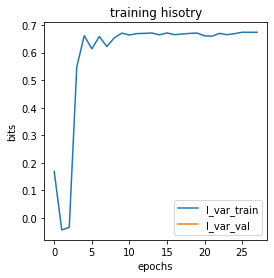

In [23]:
# Show training history
print('On test data:')
x_test = test_df['x'].values
y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')

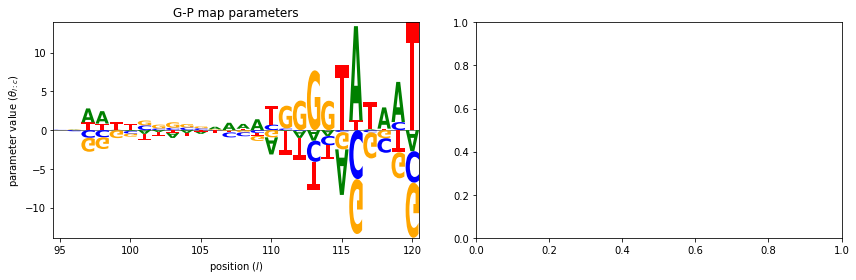

In [30]:
# Get G-P map parameters in matrix form
theta = np.squeeze(gpmap.weights[1].numpy())

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
# Y = mp_mpa.Y    # Y = number of bins
# y_lim = [-.5, Y-.5]
# y_all = range(Y)

# Compute matrix of p(y|phi) values
#measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,2,figsize=[12,4])

# Left panel: draw logo using logomaker
ax = axs[0]
logo = logomaker.Logo(-pd.DataFrame(theta,columns=model.alphabet).loc[95:120], ax=ax,center_values=True)
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters')

# Right panel: draw measurement process as heatmap
# ax = axs[1]
# im = ax.imshow(measurement_process,
#                cmap='Greens',
#                extent=phi_lim+y_lim,
#                vmin=0,
#                origin='lower',
#                interpolation='nearest',
#                aspect="auto")
# ax.set_yticks(y_all)
# ax.set_ylabel('bin number (y)')
# ax.set_xlabel('latent phenotype ($\phi$)')
# ax.set_title('measurement process')
# cb = plt.colorbar(im)
# cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
#fig.savefig('sortseq_g-p_map_mpa_visualization.png')
plt.show()